<a href="https://colab.research.google.com/github/CoGian/Detection-of-toxic-comments-and-minimization-of-unintended-model-bias-using-neural-networks/blob/master/BiGRU_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive' )

In [ ]:
import numpy as np 
import pandas as pd
import tensorflow as tf 
import random
import pickle 
import gc
import os
from sklearn import metrics
from sklearn.model_selection import train_test_split
import sys
import matplotlib.pyplot as plt
from matplotlib import gridspec
sys.path.append('/content/drive/My Drive/Jigsaw Unintended Bias in Toxicity Classification/tools')
sys.path.append('/content/drive/My Drive/Jigsaw Unintended Bias in Toxicity Classification')
from tools_benchmark import  compute_bias_metrics_for_model, calculate_overall_auc,get_final_metric
from tools_load_data import get_datasets
from tools_evaluate_model import evaluate, plot_history_for_accuracy_and_loss

# TPU Configs

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

In [ ]:
MODEL_NO = 2 
BATCH_SIZE = 512 
EPOCHS = 10

# Load Datasets

In [ ]:
 IDENTITY_COLUMNS  = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness'
  ] 

In [ ]:
train_df = pd.read_csv("/content/drive/My Drive/Jigsaw Unintended Bias in Toxicity Classification/data/train_cleared.csv")
train_df = train_df[:10000]
test_public_df = pd.read_csv("/content/drive/My Drive/Jigsaw Unintended Bias in Toxicity Classification/data/test_public_cleared.csv")
test_public_df = test_public_df.loc[:, ['toxicity','comment_text']  + IDENTITY_COLUMNS ].dropna()[:1000]
test_private_df = pd.read_csv("/content/drive/My Drive/Jigsaw Unintended Bias in Toxicity Classification/data/test_private_cleared.csv")
test_private_df = test_private_df.loc[:, ['toxicity', 'comment_text'] + IDENTITY_COLUMNS ].dropna()[:1000]

In [ ]:
# split 
train_df , val_df = train_test_split(train_df,test_size = 0.2 , random_state = 13 , shuffle = True)

In [ ]:
train_dataset,validation_dataset, public_test_dataset, private_test_dataset , embedding_matrix = get_datasets(train_df, val_df, test_public_df, test_private_df)

n unknown words (glove):  217933
n known words (glove):  491202
n unknown words (crawl):  219420
n known words (crawl):  491202


# Training and evaluation of models 

In [ ]:
class CustomStopper(tf.keras.callbacks.EarlyStopping):
    def __init__(self, monitor='val_loss',
             min_delta=0, patience=0, verbose=0, mode='auto', start_epoch = 2 , restore_best_weights = True): # add argument for starting epoch
        super(CustomStopper, self).__init__(monitor=monitor,patience=patience,min_delta=min_delta,mode=mode, restore_best_weights = restore_best_weights)
        self.start_epoch = start_epoch

    def on_epoch_end(self, epoch, logs=None):
        if epoch > self.start_epoch:
            super().on_epoch_end(epoch, logs)

In [ ]:
es = CustomStopper(start_epoch=2)

## Build model

In [ ]:
def create_BiGRU(embedding_matrix, num_of_hidden_layers , gru_units, dense_units):
  words = tf.keras.Input(shape=(None,))
  x = tf.keras.layers.Embedding(input_dim=embedding_matrix.shape[0],
                                 output_dim = embedding_matrix.shape[1],
                                 weights=[embedding_matrix], trainable=False)(words)
  x = tf.keras.layers.SpatialDropout1D(0.2)(x)
  if num_of_hidden_layers == 2 : 
    x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(gru_units,return_sequences=True))(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(gru_units,return_sequences=True))(x)
  elif num_of_hidden_layers == 3 : 
    x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(gru_units,return_sequences=True))(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(gru_units,return_sequences=True))(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(gru_units,return_sequences=True))(x)
  else:
    print("Wrong number of hidden layers")
    return
  
  
  
  avg_pool = tf.keras.layers.GlobalAveragePooling1D()(x)
  max_pool = tf.keras.layers.GlobalMaxPooling1D()(x)

  GRU_out = tf.keras.layers.concatenate([max_pool, avg_pool])

  # skip connections 
  x = tf.keras.layers.add([GRU_out,tf.keras.layers.Dense(dense_units,activation='relu')(GRU_out)]) 
  x = tf.keras.layers.add([x,tf.keras.layers.Dense(dense_units,activation='relu')(x)]) 
  
  result = tf.keras.layers.Dense(1, activation='sigmoid', name = 'target' )(x)
  aux_result =  tf.keras.layers.Dense(6, activation='sigmoid' , name = 'aux')(x)
    
  model = tf.keras.Model(inputs=words, outputs=[result, aux_result])
  model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

  return model

## Train and tune the model

In [ ]:
def train(number_of_hidden_GRU_layers, gru_units, dense_units):
  histories = [] 
  public_predictions = [] 
  private_predictions = [] 
  MODEL_NAME = "BiGRU" + str(number_of_hidden_GRU_layers)+"-"+str(gru_units)
  print("\nBiGRU" + str(number_of_hidden_GRU_layers)+"-"+str(gru_units))
  PATH = 'BiGRU/' + MODEL_NAME
      
  for i in range(MODEL_NO):
    
    with strategy.scope():
      # create model 
      BiGRU = create_BiGRU(embedding_matrix,number_of_hidden_GRU_layers, gru_units, dense_units)
    
    BiGRU.summary()
    n_steps = len(train_df) // BATCH_SIZE 
    history = BiGRU.fit(x = train_dataset,validation_data=validation_dataset , callbacks=[es] , epochs = EPOCHS 
                          ,verbose = 1 , steps_per_epoch=n_steps)   
    histories.append(history)

    public_predictions.append(BiGRU.predict(public_test_dataset, verbose=1 )[0].flatten())
    private_predictions.append(BiGRU.predict(private_test_dataset, verbose=1 )[0].flatten())
    #save memmory 
    tf.tpu.experimental.initialize_tpu_system(tpu)

  y_public_pred = np.average(public_predictions, axis =0 )
  y_private_pred = np.average(private_predictions, axis= 0)
  # save its graph 
  tf.keras.utils.plot_model(BiGRU, show_shapes= True ,show_layer_names=False, 
                  to_file='/content/drive/My Drive/Jigsaw Unintended Bias in Toxicity Classification/models/BiGRU/' + 
                  MODEL_NAME +'/BiGRU.png')
  
  evaluate(y_public_pred,y_private_pred, test_public_df, test_private_df, PATH , MODEL_NAME)
  plot_history_for_accuracy_and_loss(histories, PATH)
  
  # delete to save memmory 
  del BiGRU
  del y_public_pred
  del y_private_pred
  del histories 
  gc.collect()

### 2-LAYERS

#### BiGRU2-64

In [ ]:
number_of_hidden_GRU_layers = 2 
gru_units = 64
dense_units = 4 * gru_units # * 4 because of concanation and bidirecrionality  
train(number_of_hidden_GRU_layers, gru_units, dense_units)


BiGRU2-64


#### BiGRU2-128


BiGRU2-128
Epoch 1/10
   2/2820 [..............................] - ETA: 1:54 - loss: 1.2033 - target_loss: 0.5817 - aux_loss: 0.6216 - target_accuracy: 0.6689 - aux_accuracy: 0.0020   WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0021s vs `on_train_batch_end` time: 0.0725s). Check your callbacks.


2820/2820 [==============================] - ETA: 0s - loss: 0.4750 - target_loss: 0.3239 - aux_loss: 0.1511 - target_accuracy: 0.6995 - aux_accuracy: 0.9005WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0017s vs `on_test_batch_end` time: 0.0357s). Check your callbacks.


2820/2820 [==============================] - 234s 83ms/step - loss: 0.4750 - target_loss: 0.3239 - aux_loss: 0.1511 - target_accuracy: 0.6995 - aux_accuracy: 0.9005 - val_loss: 0.4701 - val_target_loss: 0.3211 - val_aux_loss: 0.1489 - val_target_accuracy: 0.6976 - val_aux_accuracy: 0.9043
Epoch 2/10
2820/2820 [==============================] - 233s 83ms/step - loss: 0.4603 - target_loss: 0.3144 - aux_loss: 0.1459 - target_accuracy: 0.6998 - aux_accuracy: 0.9139 - val_loss: 0.4614 - val_target_loss: 0.3155 - val_aux_loss: 0.1459 - val_target_accuracy: 0.7009 - val_aux_accuracy: 0.9522
Epoch 3/10
2820/2820 [==============================] - 234s 83ms/step - loss: 0.4542 - target_loss: 0.3102 - aux_loss: 0.1439 - target_accuracy: 0.6999 - aux_accuracy: 0.9226 - val_loss: 0.4591 - val_target_loss: 0.3139 - val_aux_loss: 0.1451 - val_target_accuracy: 0.6983 - val_aux_accuracy: 0.9414
Epoch 4/10
2820/2820 [==============================] - 238s 84ms/step - loss: 0.4516 - target_loss: 0.3083 

  1/191 [..............................] - ETA: 0sWARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0016s vs `on_predict_batch_end` time: 0.0271s). Check your callbacks.


191/191 [==============================] - 5s 28ms/step


INFO:tensorflow:Initializing the TPU system: grpc://10.97.235.138:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.97.235.138:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/10
   2/2820 [..............................] - ETA: 1:54 - loss: 1.1839 - target_loss: 0.5133 - aux_loss: 0.6706 - target_accuracy: 0.6953 - aux_accuracy: 0.0088WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0022s vs `on_train_batch_end` time: 0.0711s). Check your callbacks.


2820/2820 [==============================] - ETA: 0s - loss: 0.4767 - target_loss: 0.3250 - aux_loss: 0.1517 - target_accuracy: 0.6991 - aux_accuracy: 0.9001WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0017s vs `on_test_batch_end` time: 0.0393s). Check your callbacks.


2820/2820 [==============================] - 236s 84ms/step - loss: 0.4767 - target_loss: 0.3250 - aux_loss: 0.1517 - target_accuracy: 0.6991 - aux_accuracy: 0.9001 - val_loss: 0.4616 - val_target_loss: 0.3152 - val_aux_loss: 0.1463 - val_target_accuracy: 0.7001 - val_aux_accuracy: 0.9100
Epoch 2/10
2820/2820 [==============================] - 233s 83ms/step - loss: 0.4592 - target_loss: 0.3136 - aux_loss: 0.1456 - target_accuracy: 0.6998 - aux_accuracy: 0.9123 - val_loss: 0.4604 - val_target_loss: 0.3145 - val_aux_loss: 0.1459 - val_target_accuracy: 0.7007 - val_aux_accuracy: 0.9294
Epoch 3/10
2820/2820 [==============================] - 232s 82ms/step - loss: 0.4542 - target_loss: 0.3102 - aux_loss: 0.1440 - target_accuracy: 0.7003 - aux_accuracy: 0.9244 - val_loss: 0.4598 - val_target_loss: 0.3142 - val_aux_loss: 0.1456 - val_target_accuracy: 0.7001 - val_aux_accuracy: 0.9082
Epoch 4/10
2820/2820 [==============================] - 237s 84ms/step - loss: 0.4515 - target_loss: 0.3083 

  1/191 [..............................] - ETA: 0sWARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0016s vs `on_predict_batch_end` time: 0.0278s). Check your callbacks.


191/191 [==============================] - 5s 28ms/step


INFO:tensorflow:Initializing the TPU system: grpc://10.97.235.138:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.97.235.138:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Accuracy on public test: 0.953319
Accuracy on private test: 0.953709
Public AUC score : 0.931657
Private AUC score : 0.933297


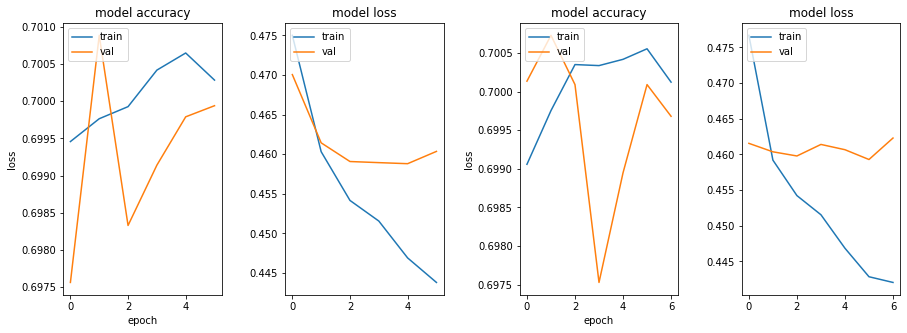

In [ ]:
number_of_hidden_GRU_layers = 2 
gru_units = 128
dense_units = 4 * gru_units # * 4 because of concanation and bidirecrionality  
train(number_of_hidden_GRU_layers, gru_units, dense_units)

#### BiGRU2-256


BiGRU2-256
Epoch 1/10
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


   2/2820 [..............................] - ETA: 2:33 - loss: 1.3830 - target_loss: 0.9006 - aux_loss: 0.4825 - target_accuracy: 0.6973 - aux_accuracy: 0.2627WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0021s vs `on_train_batch_end` time: 0.0979s). Check your callbacks.


2820/2820 [==============================] - ETA: 0s - loss: 0.4741 - target_loss: 0.3235 - aux_loss: 0.1506 - target_accuracy: 0.6995 - aux_accuracy: 0.8988WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0018s vs `on_test_batch_end` time: 0.0457s). Check your callbacks.


2820/2820 [==============================] - 311s 110ms/step - loss: 0.4741 - target_loss: 0.3235 - aux_loss: 0.1506 - target_accuracy: 0.6995 - aux_accuracy: 0.8988 - val_loss: 0.4651 - val_target_loss: 0.3178 - val_aux_loss: 0.1473 - val_target_accuracy: 0.6979 - val_aux_accuracy: 0.9272
Epoch 2/10
2820/2820 [==============================] - 309s 110ms/step - loss: 0.4588 - target_loss: 0.3135 - aux_loss: 0.1454 - target_accuracy: 0.7003 - aux_accuracy: 0.9124 - val_loss: 0.4609 - val_target_loss: 0.3155 - val_aux_loss: 0.1455 - val_target_accuracy: 0.6989 - val_aux_accuracy: 0.8942
Epoch 3/10
2820/2820 [==============================] - 309s 109ms/step - loss: 0.4518 - target_loss: 0.3084 - aux_loss: 0.1434 - target_accuracy: 0.7002 - aux_accuracy: 0.9203 - val_loss: 0.4583 - val_target_loss: 0.3133 - val_aux_loss: 0.1450 - val_target_accuracy: 0.7004 - val_aux_accuracy: 0.9076
Epoch 4/10
2820/2820 [==============================] - 313s 111ms/step - loss: 0.4469 - target_loss: 0.3

  1/191 [..............................] - ETA: 0sWARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0014s vs `on_predict_batch_end` time: 0.0316s). Check your callbacks.


191/191 [==============================] - 6s 33ms/step


INFO:tensorflow:Initializing the TPU system: grpc://10.65.69.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.65.69.50:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/10
   2/2820 [..............................] - ETA: 2:26 - loss: 1.4862 - target_loss: 0.9529 - aux_loss: 0.5334 - target_accuracy: 0.3701 - aux_accuracy: 0.9629WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0022s vs `on_train_batch_end` time: 0.0944s). Check your callbacks.


2820/2820 [==============================] - ETA: 0s - loss: 0.4738 - target_loss: 0.3234 - aux_loss: 0.1504 - target_accuracy: 0.6995 - aux_accuracy: 0.8985WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0017s vs `on_test_batch_end` time: 0.0439s). Check your callbacks.


2820/2820 [==============================] - 313s 111ms/step - loss: 0.4738 - target_loss: 0.3234 - aux_loss: 0.1504 - target_accuracy: 0.6995 - aux_accuracy: 0.8985 - val_loss: 0.4622 - val_target_loss: 0.3159 - val_aux_loss: 0.1463 - val_target_accuracy: 0.6991 - val_aux_accuracy: 0.9206
Epoch 2/10
2820/2820 [==============================] - 310s 110ms/step - loss: 0.4576 - target_loss: 0.3125 - aux_loss: 0.1451 - target_accuracy: 0.7000 - aux_accuracy: 0.9114 - val_loss: 0.4614 - val_target_loss: 0.3158 - val_aux_loss: 0.1456 - val_target_accuracy: 0.7001 - val_aux_accuracy: 0.9050
Epoch 3/10
2820/2820 [==============================] - 308s 109ms/step - loss: 0.4539 - target_loss: 0.3101 - aux_loss: 0.1439 - target_accuracy: 0.6999 - aux_accuracy: 0.9207 - val_loss: 0.4581 - val_target_loss: 0.3131 - val_aux_loss: 0.1450 - val_target_accuracy: 0.6996 - val_aux_accuracy: 0.9220
Epoch 4/10
2820/2820 [==============================] - 314s 111ms/step - loss: 0.4466 - target_loss: 0.3

  1/191 [..............................] - ETA: 0sWARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0015s vs `on_predict_batch_end` time: 0.0322s). Check your callbacks.


191/191 [==============================] - 6s 33ms/step


INFO:tensorflow:Initializing the TPU system: grpc://10.65.69.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.65.69.50:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Accuracy on public test: 0.952517
Accuracy on private test: 0.953216
Public AUC score : 0.932302
Private AUC score : 0.933735


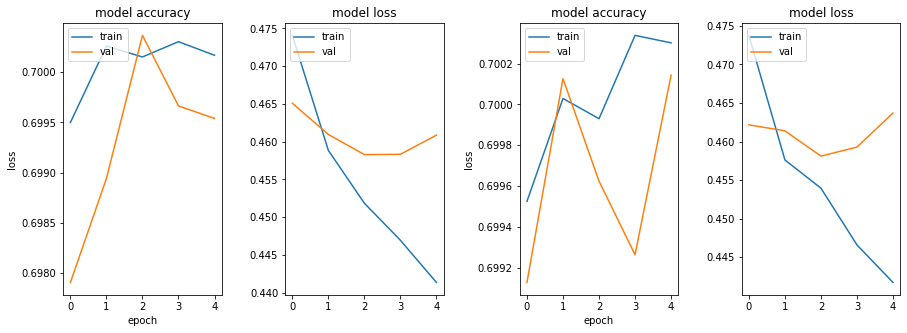

In [ ]:
number_of_hidden_GRU_layers = 2 
gru_units = 256
dense_units = 4 * gru_units # * 4 because of concanation and bidirecrionality  
train(number_of_hidden_GRU_layers, gru_units, dense_units)

### 3-LAYERS

#### BiGRU3-64

In [ ]:
number_of_hidden_GRU_layers = 3 
gru_units = 64
dense_units = 4 * gru_units
train(number_of_hidden_GRU_layers, gru_units, dense_units)


BiGRU3-64


#### BiGRU3-128


BiGRU3-128
Epoch 1/10
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


   2/2820 [..............................] - ETA: 2:13 - loss: 1.1310 - target_loss: 0.5709 - aux_loss: 0.5601 - target_accuracy: 0.6680 - aux_accuracy: 0.0967WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0023s vs `on_train_batch_end` time: 0.0863s). Check your callbacks.


2820/2820 [==============================] - ETA: 0s - loss: 0.4743 - target_loss: 0.3235 - aux_loss: 0.1508 - target_accuracy: 0.6996 - aux_accuracy: 0.9030WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0017s vs `on_test_batch_end` time: 0.0411s). Check your callbacks.


2820/2820 [==============================] - 281s 100ms/step - loss: 0.4743 - target_loss: 0.3235 - aux_loss: 0.1508 - target_accuracy: 0.6996 - aux_accuracy: 0.9030 - val_loss: 0.4636 - val_target_loss: 0.3171 - val_aux_loss: 0.1464 - val_target_accuracy: 0.7004 - val_aux_accuracy: 0.9245
Epoch 2/10
2820/2820 [==============================] - 278s 99ms/step - loss: 0.4591 - target_loss: 0.3135 - aux_loss: 0.1456 - target_accuracy: 0.6999 - aux_accuracy: 0.9144 - val_loss: 0.4592 - val_target_loss: 0.3138 - val_aux_loss: 0.1454 - val_target_accuracy: 0.6998 - val_aux_accuracy: 0.9183
Epoch 3/10
2820/2820 [==============================] - 280s 99ms/step - loss: 0.4546 - target_loss: 0.3105 - aux_loss: 0.1442 - target_accuracy: 0.7000 - aux_accuracy: 0.9238 - val_loss: 0.4573 - val_target_loss: 0.3124 - val_aux_loss: 0.1449 - val_target_accuracy: 0.7001 - val_aux_accuracy: 0.9439
Epoch 4/10
2820/2820 [==============================] - 282s 100ms/step - loss: 0.4497 - target_loss: 0.307

  1/191 [..............................] - ETA: 0sWARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0017s vs `on_predict_batch_end` time: 0.0305s). Check your callbacks.


191/191 [==============================] - 6s 32ms/step


INFO:tensorflow:Initializing the TPU system: grpc://10.13.191.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.13.191.122:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/10
   2/2820 [..............................] - ETA: 2:28 - loss: 1.1484 - target_loss: 0.6029 - aux_loss: 0.5455 - target_accuracy: 0.3643 - aux_accuracy: 0.3945WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0022s vs `on_train_batch_end` time: 0.0954s). Check your callbacks.


2820/2820 [==============================] - ETA: 0s - loss: 0.4758 - target_loss: 0.3245 - aux_loss: 0.1514 - target_accuracy: 0.6991 - aux_accuracy: 0.9045WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0018s vs `on_test_batch_end` time: 0.0441s). Check your callbacks.


2820/2820 [==============================] - 282s 100ms/step - loss: 0.4758 - target_loss: 0.3245 - aux_loss: 0.1514 - target_accuracy: 0.6991 - aux_accuracy: 0.9045 - val_loss: 0.4632 - val_target_loss: 0.3168 - val_aux_loss: 0.1464 - val_target_accuracy: 0.7003 - val_aux_accuracy: 0.9121
Epoch 2/10
2820/2820 [==============================] - 280s 99ms/step - loss: 0.4595 - target_loss: 0.3139 - aux_loss: 0.1456 - target_accuracy: 0.7001 - aux_accuracy: 0.9172 - val_loss: 0.4585 - val_target_loss: 0.3134 - val_aux_loss: 0.1451 - val_target_accuracy: 0.7000 - val_aux_accuracy: 0.8965
Epoch 3/10
2820/2820 [==============================] - 280s 99ms/step - loss: 0.4545 - target_loss: 0.3104 - aux_loss: 0.1441 - target_accuracy: 0.7000 - aux_accuracy: 0.9269 - val_loss: 0.4575 - val_target_loss: 0.3128 - val_aux_loss: 0.1448 - val_target_accuracy: 0.6995 - val_aux_accuracy: 0.9520
Epoch 4/10
2820/2820 [==============================] - 286s 101ms/step - loss: 0.4484 - target_loss: 0.306

  1/191 [..............................] - ETA: 0sWARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0014s vs `on_predict_batch_end` time: 0.0305s). Check your callbacks.


191/191 [==============================] - 6s 31ms/step


INFO:tensorflow:Initializing the TPU system: grpc://10.13.191.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.13.191.122:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Accuracy on public test: 0.952867
Accuracy on private test: 0.952826
Public AUC score : 0.931684
Private AUC score : 0.933752


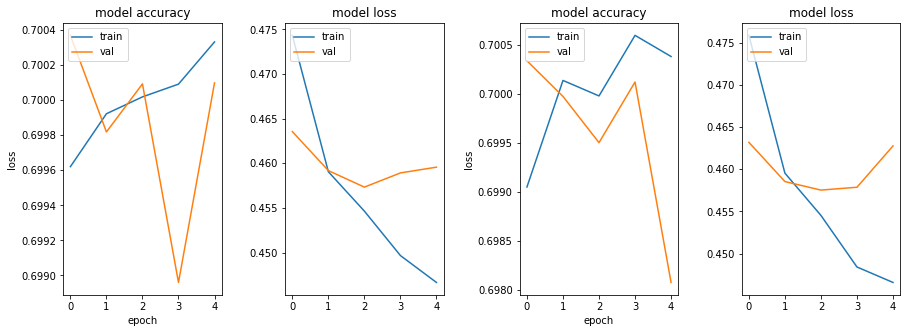

In [ ]:
number_of_hidden_GRU_layers = 3 
gru_units = 128
dense_units = 4 * gru_units
train(number_of_hidden_GRU_layers, gru_units, dense_units)

#### BiGRU3-256


BiGRU3-256
Epoch 1/10
   2/2820 [..............................] - ETA: 3:13 - loss: 1.2167 - target_loss: 0.7720 - aux_loss: 0.4447 - target_accuracy: 0.7021 - aux_accuracy: 0.9648WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0023s vs `on_train_batch_end` time: 0.1268s). Check your callbacks.


2820/2820 [==============================] - ETA: 0s - loss: 0.4747 - target_loss: 0.3240 - aux_loss: 0.1507 - target_accuracy: 0.6991 - aux_accuracy: 0.8955WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0018s vs `on_test_batch_end` time: 0.0499s). Check your callbacks.


2820/2820 [==============================] - 408s 145ms/step - loss: 0.4747 - target_loss: 0.3240 - aux_loss: 0.1507 - target_accuracy: 0.6991 - aux_accuracy: 0.8955 - val_loss: 0.4640 - val_target_loss: 0.3170 - val_aux_loss: 0.1469 - val_target_accuracy: 0.7001 - val_aux_accuracy: 0.8328
Epoch 2/10
2820/2820 [==============================] - 406s 144ms/step - loss: 0.4574 - target_loss: 0.3124 - aux_loss: 0.1450 - target_accuracy: 0.6997 - aux_accuracy: 0.9074 - val_loss: 0.4606 - val_target_loss: 0.3153 - val_aux_loss: 0.1454 - val_target_accuracy: 0.6985 - val_aux_accuracy: 0.9648
Epoch 3/10
2820/2820 [==============================] - 405s 143ms/step - loss: 0.4527 - target_loss: 0.3091 - aux_loss: 0.1436 - target_accuracy: 0.7006 - aux_accuracy: 0.9216 - val_loss: 0.4587 - val_target_loss: 0.3134 - val_aux_loss: 0.1453 - val_target_accuracy: 0.6989 - val_aux_accuracy: 0.8829
Epoch 4/10
2820/2820 [==============================] - 410s 145ms/step - loss: 0.4462 - target_loss: 0.3

  1/191 [..............................] - ETA: 0sWARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0015s vs `on_predict_batch_end` time: 0.0390s). Check your callbacks.


191/191 [==============================] - 8s 40ms/step


INFO:tensorflow:Initializing the TPU system: grpc://10.13.191.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.13.191.122:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/10
   2/2820 [..............................] - ETA: 3:12 - loss: 1.3027 - target_loss: 0.8464 - aux_loss: 0.4563 - target_accuracy: 0.6992 - aux_accuracy: 0.1904WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0024s vs `on_train_batch_end` time: 0.1283s). Check your callbacks.


2820/2820 [==============================] - ETA: 0s - loss: 0.4760 - target_loss: 0.3248 - aux_loss: 0.1511 - target_accuracy: 0.6990 - aux_accuracy: 0.8936WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0018s vs `on_test_batch_end` time: 0.0508s). Check your callbacks.


2820/2820 [==============================] - 407s 144ms/step - loss: 0.4760 - target_loss: 0.3248 - aux_loss: 0.1511 - target_accuracy: 0.6990 - aux_accuracy: 0.8936 - val_loss: 0.4652 - val_target_loss: 0.3182 - val_aux_loss: 0.1470 - val_target_accuracy: 0.6981 - val_aux_accuracy: 0.9295
Epoch 2/10
2820/2820 [==============================] - 405s 144ms/step - loss: 0.4578 - target_loss: 0.3127 - aux_loss: 0.1451 - target_accuracy: 0.7001 - aux_accuracy: 0.9161 - val_loss: 0.4581 - val_target_loss: 0.3132 - val_aux_loss: 0.1450 - val_target_accuracy: 0.6995 - val_aux_accuracy: 0.8694
Epoch 3/10
2820/2820 [==============================] - 405s 144ms/step - loss: 0.4512 - target_loss: 0.3081 - aux_loss: 0.1431 - target_accuracy: 0.7006 - aux_accuracy: 0.9277 - val_loss: 0.4575 - val_target_loss: 0.3127 - val_aux_loss: 0.1448 - val_target_accuracy: 0.7001 - val_aux_accuracy: 0.9505
Epoch 4/10
2820/2820 [==============================] - 410s 145ms/step - loss: 0.4460 - target_loss: 0.3

  1/191 [..............................] - ETA: 0sWARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0015s vs `on_predict_batch_end` time: 0.0411s). Check your callbacks.


191/191 [==============================] - 8s 40ms/step


INFO:tensorflow:Initializing the TPU system: grpc://10.13.191.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.13.191.122:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Accuracy on public test: 0.953072
Accuracy on private test: 0.953052
Public AUC score : 0.933233
Private AUC score : 0.933193


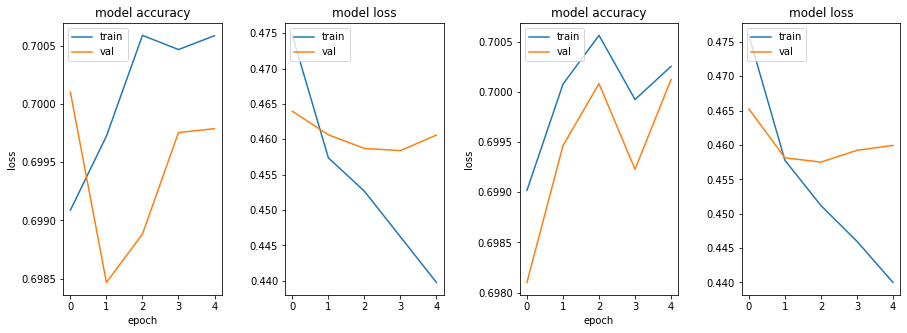

In [ ]:
number_of_hidden_GRU_layers = 3
gru_units = 256
dense_units = 4 * gru_units
train(number_of_hidden_GRU_layers, gru_units, dense_units)

## TextCNN

In [ ]:
def ConvNet2(embedding_matrix,num_aux_targets):
  words = tf.keras.Input(shape=(None,))
  x = tf.keras.layers.Embedding(*embedding_matrix.shape, weights=[embedding_matrix], trainable=False)(words)
  convs = []
  filter_sizes = [2,3,4,5,6]

  for filter_size in filter_sizes:
    l_conv = tf.keras.layers.Conv1D(filters=200, 
                        kernel_size=filter_size, 
                        activation='relu')(x)
    l_pool =tf.keras.layers.GlobalMaxPooling1D()(l_conv)
    convs.append(l_pool)
  
  l_merge = tf.concat(convs, axis=1)
  x = tf.keras.layers.Dropout(0.1)(l_merge)  
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  result = tf.keras.layers.Dense(1, activation='sigmoid', name = 'target')(x)
  aux_result =  tf.keras.layers.Dense(num_aux_targets, activation='sigmoid', name = 'aux')(x)

  model = tf.keras.Model(inputs=words, outputs=[result, aux_result])
  model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

  return model 

In [ ]:
model = ConvNet2(embedding_matrix, y_train_aux.shape[-1])
model.fit(train_dataset, epochs=EPOCHS , callbacks=[callback])